In [3]:
!unzip archive\ \(27\).zip


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Dataset/F0/a7378.jpg  
  inflating: Dataset/Dataset/F0/a738.jpg  
  inflating: Dataset/Dataset/F0/a7384.jpg  
  inflating: Dataset/Dataset/F0/a7405.jpg  
  inflating: Dataset/Dataset/F0/a741.jpg  
  inflating: Dataset/Dataset/F0/a7410.jpg  
  inflating: Dataset/Dataset/F0/a7412.jpg  
  inflating: Dataset/Dataset/F0/a7415.jpg  
  inflating: Dataset/Dataset/F0/a7425.jpg  
  inflating: Dataset/Dataset/F0/a7431.jpg  
  inflating: Dataset/Dataset/F0/a7435.jpg  
  inflating: Dataset/Dataset/F0/a7446.jpg  
  inflating: Dataset/Dataset/F0/a7448.jpg  
  inflating: Dataset/Dataset/F0/a7460.jpg  
  inflating: Dataset/Dataset/F0/a7464.jpg  
  inflating: Dataset/Dataset/F0/a747.jpg  
  inflating: Dataset/Dataset/F0/a7470.jpg  
  inflating: Dataset/Dataset/F0/a7496.jpg  
  inflating: Dataset/Dataset/F0/a7505.jpg  
  inflating: Dataset/Dataset/F0/a7514.jpg  
  inflating: Dataset/Dataset/F0/a7515.jpg  
  inflating: Dataset/Dataset

In [4]:
import os, json, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("TF version:", tf.__version__)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


TF version: 2.19.0


In [5]:
DATA_DIR = "/content/Dataset/Dataset"  # <-- CHANGE THIS

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("Folders:", os.listdir(DATA_DIR)[:10])


DATA_DIR exists: True
Folders: ['F1', 'F3', 'F2', 'F4', 'F0']


In [6]:
valid_ext = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Classes:", class_names)

filepaths, labels = [], []
for cls in class_names:
    cls_path = os.path.join(DATA_DIR, cls)
    for root, _, files in os.walk(cls_path):
        for f in files:
            if f.endswith(valid_ext):
                filepaths.append(os.path.join(root, f))
                labels.append(cls)

df = pd.DataFrame({"filepath": filepaths, "label": labels})
print("Total images:", len(df))
print(df["label"].value_counts())

label2id = {c:i for i,c in enumerate(class_names)}
id2label = {i:c for c,i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=SEED, stratify=df["label_id"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["label_id"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Classes: ['F0', 'F1', 'F2', 'F3', 'F4']
Total images: 6323
label
F0    2114
F4    1698
F1     861
F3     857
F2     793
Name: count, dtype: int64
Train: 4426 Val: 948 Test: 949


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)        # jpg dataset
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)                     # keep 0..255
    label = tf.cast(label, tf.int32)
    return img, label

def make_dataset(dataframe, shuffle=True):
    paths = dataframe["filepath"].values
    labels = dataframe["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df, shuffle=False)
test_ds  = make_dataset(test_df, shuffle=False)

for x, y in train_ds.take(1):
    print("Batch:", x.shape, y.shape)


Batch: (16, 224, 224, 3) (16,)


In [8]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

num_classes = len(class_names)

data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.10),
], name="augmentation")

base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_aug(inputs)
x = preprocess_input(x)         # ✅ critical for EfficientNet
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
y_train = train_df["label_id"].values
cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(cw)}
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.5981081081081081), 1: np.float64(1.4679933665008291), 2: np.float64(1.5949549549549549), 3: np.float64(1.4753333333333334), 4: np.float64(0.7451178451178451)}


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ckpt_path = "best_fibrosis.weights.h5"

callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True,
                    save_weights_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/15
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4640 - loss: 1.2784
Epoch 1: val_accuracy improved from -inf to 0.63502, saving model to best_fibrosis.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.4645 - loss: 1.2774 - val_accuracy: 0.6350 - val_loss: 0.8869 - learning_rate: 3.0000e-04
Epoch 2/15
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6234 - loss: 0.9812
Epoch 2: val_accuracy improved from 0.63502 to 0.66667, saving model to best_fibrosis.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.6235 - loss: 0.9811 - val_accuracy: 0.6667 - val_loss: 0.8347 - learning_rate: 3.0000e-04
Epoch 3/15
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6693 - loss: 0.9010
Epoch 3: val_accuracy did not improve from 0.66667
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6693 - loss: 0.9009 - val_accuracy: 0.6635 - val_loss: 0.7902 - learning_rate: 3.0000e-04
Epoch 4/15
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - a

In [11]:
model.load_weights(ckpt_path)

base.trainable = True
# unfreeze last 40 layers only
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6185 - loss: 1.0165
Epoch 1: val_accuracy did not improve from 0.76899
277/277 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.6187 - loss: 1.0158 - val_accuracy: 0.7131 - val_loss: 0.7025 - learning_rate: 1.0000e-05
Epoch 2/10
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7083 - loss: 0.7980
Epoch 2: val_accuracy did not improve from 0.76899
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.7084 - loss: 0.7979 - val_accuracy: 0.7184 - val_loss: 0.6619 - learning_rate: 1.0000e-05
Epoch 3/10
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7429 - loss: 0.7222
Epoch 3: val_accuracy did not improve from 0.76899
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7428 - loss: 0.7222 - val_accuracy: 0.7247 - val_loss: 0.6527 - learning_rate: 1.0000e-05
Epoch 4/10
276/277 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7554 - loss: 0.6967
Epoch 4: val_accuracy did not improve from 0.76899
277/277

✅ Test Accuracy: 0.7998 | Loss: 0.4871

Classification Report:
              precision    recall  f1-score   support

          F0       0.96      0.95      0.95       317
          F1       0.60      0.81      0.69       129
          F2       0.71      0.61      0.65       119
          F3       0.82      0.48      0.60       129
          F4       0.77      0.86      0.82       255

    accuracy                           0.80       949
   macro avg       0.77      0.74      0.74       949
weighted avg       0.81      0.80      0.80       949



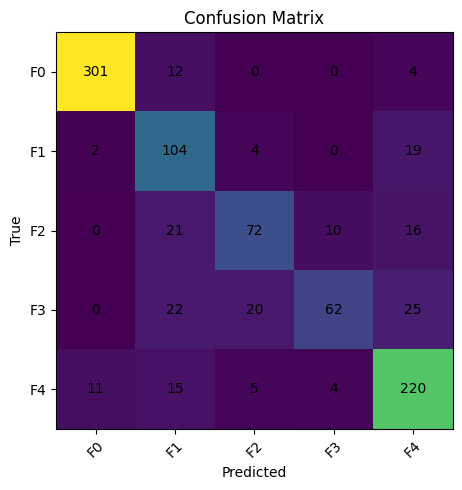

In [12]:
model.load_weights(ckpt_path)

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# predictions
y_true = test_df["label_id"].values
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


In [13]:
model.load_weights(ckpt_path)

model.save("liver_fibrosis_stage_model.h5")   # ✅ most compatible for deployment
print("✅ Saved: liver_fibrosis_stage_model.h5")

with open("label_map.json", "w") as f:
    json.dump({"class_names": class_names, "label2id": label2id, "id2label": id2label}, f, indent=2)

print("✅ Saved: label_map.json")


✅ Saved: liver_fibrosis_stage_model.h5
✅ Saved: label_map.json


In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import sklearn

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy version: 2.0.2
Pandas version: 2.2.2
TensorFlow version: 2.19.0
Matplotlib version: 3.10.0
Scikit-learn version: 1.6.1


In [2]:
import PIL
print(PIL.__version__)


11.3.0
